In [43]:
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torchaudio

import os
from os.path import join as opj
from os.path import join, exists, split
import time
import urllib.request
import warnings
from tqdm import tqdm
from pprint import pprint
import zipfile
import glob
warnings.filterwarnings('ignore')

# from glmsingle.glmsingle import GLM_single
import pandas as pd
from nilearn import maskers
from nilearn import plotting
import tqdm

from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import concat_imgs, mean_img
import matplotlib.pyplot as plt
import nilearn
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_contrast_matrix

default_n_threads = 64
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"


In [44]:
base_data_path="/data01/data/fMRI_music_genre/ds003720/derivatives"  # -download
base_event_path="/data01/data/fMRI_music_genre/ds003720"

subj="sub-001"

data_path=opj(base_data_path,subj,"func")
# event_path=opj(base_data_path,"events")

stim_dir="/data01/data/fMRI_music_genre/data_wav/genres_original"


sessions=os.listdir(data_path)

# training_stimuli= pd.read_csv(opj(base_data_path,"stimulus_ImageNetTraining.tsv"),sep="\t",names=["stimulus_id","category","label","idx"],header=None,dtype={"stimulus_id":str,"category":str,"label":int,"idx":int})
# test_stimuli= pd.read_csv(opj(base_data_path,"stimulus_ImageNetTest.tsv"),sep="\t",names=["stimulus_id","category","label","idx"],header=None,dtype={"stimulus_id":str,"category":str,"label":int,"idx":int})

In [45]:
filenames=glob.glob(opj(data_path,"*-preproc_bold.nii.gz"))

In [46]:
data=[]
events=[]
drop_first=0



for fn in tqdm.tqdm(filenames):
    #load file
    print(data_path,fn)
    
    name=fn.split("/")[-1].replace("_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz","_events.tsv")
    
    events_path=opj(base_event_path,subj,"func",name)
    # print(opj(data_path_ses,fn),opj(event_path,fn.replace('_bold_preproc.nii.gz','_events.tsv')))

    x=nib.load(fn)
    # df=pd.read_csv(fn.replace('_bold.nii','_events.tsv'),sep='\t',)
    df=pd.read_csv(events_path,sep='\t',)
    
    events.append(df)
    data.append(x)

100%|██████████| 18/18 [00:00<00:00, 421.79it/s]

/data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func/sub-001_task-Test_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func/sub-001_task-Test_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func/sub-001_task-Test_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func/sub-001_task-Test_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func/sub-001_task-Training_run-03_space-MNI152NLin2009cAsym_d

In [47]:
masker = maskers.NiftiMasker(mask_strategy="epi")
masker.fit(data[0])
report = masker.generate_report()



In [48]:
report

In [49]:
mask=False
tgt_dir=f"/data01/data/fMRI_music_genre/fmri_preproc_data/{subj}"

if mask:
    for i in tqdm.trange(len(data)):
        data[i]=masker.transform_single_imgs(data[i]).T
    
    os.makedirs(tgt_dir,exist_ok=True)

    for i in range(len(data)):
        print(data[i].shape)
        print(f"{tgt_dir}/{filenames[i].split('/')[-1].replace('.nii.gz','.npy')}")
        np.save(f"{tgt_dir}/{filenames[i].split('/')[-1].replace('.nii.gz','.npy')}",data[i])
else:
    for i,f in enumerate(filenames):
        data[i]=np.load(f"{tgt_dir}/{f.split('/')[-1].replace('.nii.gz','.npy')}")

In [50]:
for e in events:
    # e["category"]=e["genre"]+e["track"]
    e['category'] = e.apply(lambda row: f"{row['genre']}_{row['track']}", axis=1)    
    e["trial_type"]=e["category"]


In [51]:
TR=1.5
cleaned_data=[nilearn.signal.clean(d.T,detrend=True,standardize=True,t_r=TR) for d in data] # detrend and standardize
# nii_cleaned_data=[masker.inverse_transform(i) for i in cleaned_data]


## Prepare dataset

1) Save fMRI activity of each stim and related audio for all runs
2) Encode all audio
3) Clustering
4) Average fMRI activity
5) Can we predict music cluster from fMRI?

In [52]:
train_fmri=[]
test_fmri=[]
train_audio=[]
test_audio=[]
train_sr=[]
test_sr=[]

train_genre=[]
test_genre=[]

TR=1.5
stimdur=10
how_many_fmri_vols=10
fmri_vol_delay=3

for run_data, run_event, fn in zip(cleaned_data, events, filenames):
    print(fn)
    
    for i in range(len(run_event)):
        start_vol=(run_event.iloc[i].onset//TR).astype(np.int64) + fmri_vol_delay

        tmp_fmri_data=run_data[start_vol:start_vol+how_many_fmri_vols]
        tmp_stim=opj(stim_dir,run_event.iloc[i].genre.replace("'",""),run_event.iloc[i].genre.replace("'","")+"."+f"{run_event.iloc[i].track}".zfill(5)+".wav")
        audio,sr=torchaudio.load(tmp_stim)
        
        if "task-Test" in fn:
            test_fmri.append(tmp_fmri_data)
            test_audio.append(audio)
            test_sr.append(sr)
            test_genre.append(run_event.iloc[i].genre.replace("'",""))

        elif "task-Training" in fn:
            train_fmri.append(tmp_fmri_data)
            train_audio.append(audio)
            train_sr.append(sr)
            train_genre.append(run_event.iloc[i].genre.replace("'",""))

    
# train_fmri=torch.tensor(np.stack(train_fmri,0))
# test_fmri=torch.tensor(np.stack(test_fmri,0))

train_fmri_avg=[]
test_fmri_avg=[]
for f in tqdm.tqdm(train_fmri):
    train_fmri_avg.append(f.mean(0))
for f in tqdm.tqdm(test_fmri):
    test_fmri_avg.append(f.mean(0))
train_fmri_avg=torch.tensor(train_fmri_avg)
test_fmri_avg=torch.tensor(test_fmri_avg)






/data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func/sub-001_task-Test_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func/sub-001_task-Test_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func/sub-001_task-Test_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func/sub-001_task-Test_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func/sub-001_task-Training_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func/sub-001_task-Test_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720/derivatives/sub-001/func/sub-001_task-Training_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data

100%|██████████| 246/246 [00:00<00:00, 1575.50it/s]


In [53]:
train_genre=np.array(train_genre)
test_genre=np.array(test_genre)


In [54]:
# train_sr

In [55]:
from transformers import AutoFeatureExtractor, ClapModel

model = ClapModel.from_pretrained("laion/clap-htsat-unfused")
feature_extractor = AutoFeatureExtractor.from_pretrained("laion/clap-htsat-unfused")
random_audio = torch.rand((16_000))
inputs = feature_extractor(random_audio, return_tensors="pt")
audio_features = model.get_audio_features(**inputs)

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [56]:
train_audio_feat=[]
test_audio_feat=[]

with torch.no_grad():
    for wv,sr in tqdm.tqdm(zip(train_audio,train_sr)):
        inputs = feature_extractor(wv.squeeze(), return_tensors="pt",sampling_rate=48_000)
        audio_features = model.get_audio_features(**inputs)
        train_audio_feat.append(audio_features)

with torch.no_grad():
    for wv,sr in tqdm.tqdm(zip(test_audio,train_sr)):
        inputs = feature_extractor(wv.squeeze(), return_tensors="pt",sampling_rate=48_000)
        audio_features = model.get_audio_features(**inputs)
        test_audio_feat.append(audio_features)

    
    

492it [01:09,  7.13it/s]
246it [00:35,  6.89it/s]


In [57]:
train_audio_feat=torch.stack(train_audio_feat).squeeze()
test_audio_feat=torch.stack(test_audio_feat).squeeze()


In [58]:
# with torch.no_grad():
#     for wv,sr in tqdm.tqdm(zip(test_audio,train_sr)):
#         inputs = feature_extractor(wv.squeeze(), return_tensors="pt",sampling_rate=48_000)
#         audio_features = model.get_audio_features(**inputs)
#         test_audio_feat.append(audio_features)

    

In [59]:
from sklearn.cluster import KMeans

# Choose the number of clusters
n_clusters = 10  # Example, adjust based on your data

# Apply K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(train_audio_feat)

In [60]:
from sklearn.manifold import TSNE

# Initialize t-SNE with 2 components (2D visualization)
tsne = TSNE(n_components=2, random_state=42)

# Apply t-SNE to the scaled features
tsne_features = tsne.fit_transform(train_audio_feat)

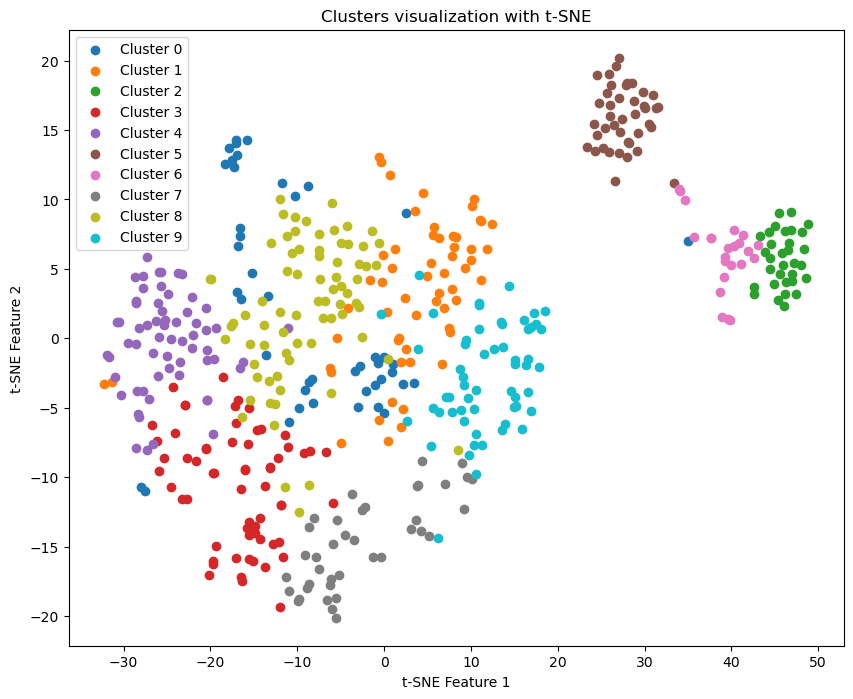

In [61]:
# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(tsne_features[clusters == i, 0], tsne_features[clusters == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title('Clusters visualization with t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()


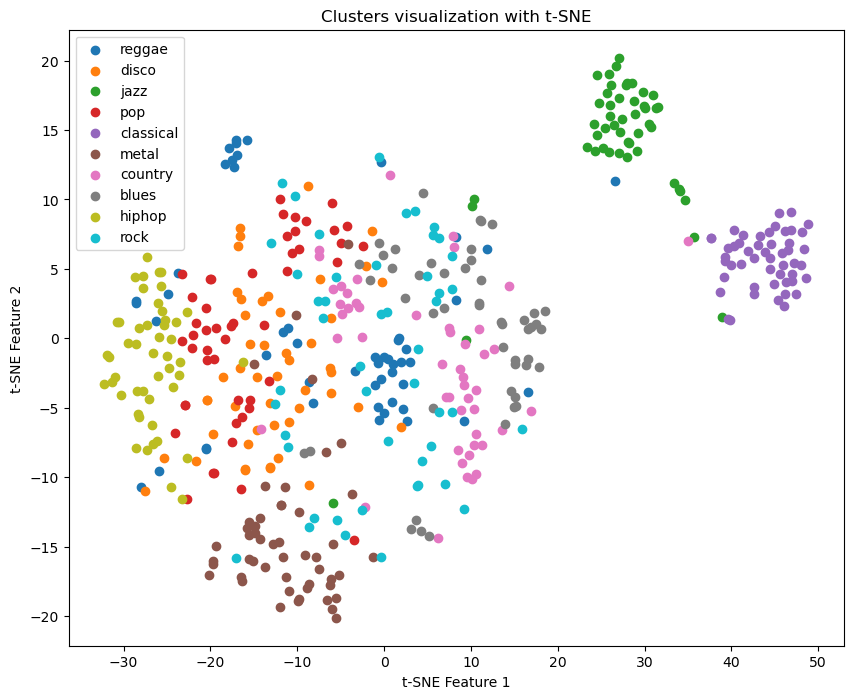

In [62]:
# Plot the clusters
plt.figure(figsize=(10, 8))
genres=set(train_genre)
for i,g in zip(range(n_clusters),genres):
    plt.scatter(tsne_features[train_genre == g, 0], tsne_features[train_genre ==g, 1], label=f'{g}')
plt.legend()
plt.title('Clusters visualization with t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()


In [63]:
# train_fmri_avg=train_fmri.mean(1)
# test_fmri_avg=test_fmri.mean(1)


## Build an encoding model to find relevant voxels in the brain

score 0.046007737582100416: 100%|██████████| 237653/237653 [4:47:27<00:00, 13.78it/s]  


833


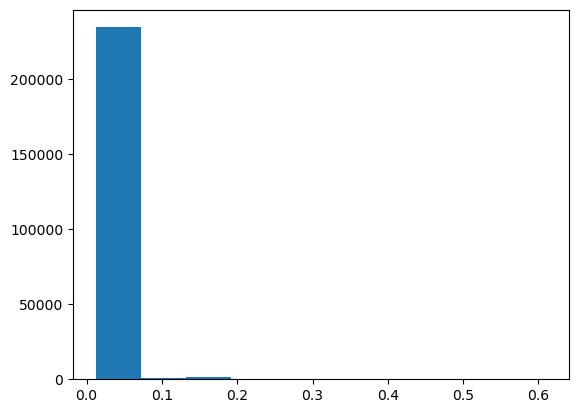

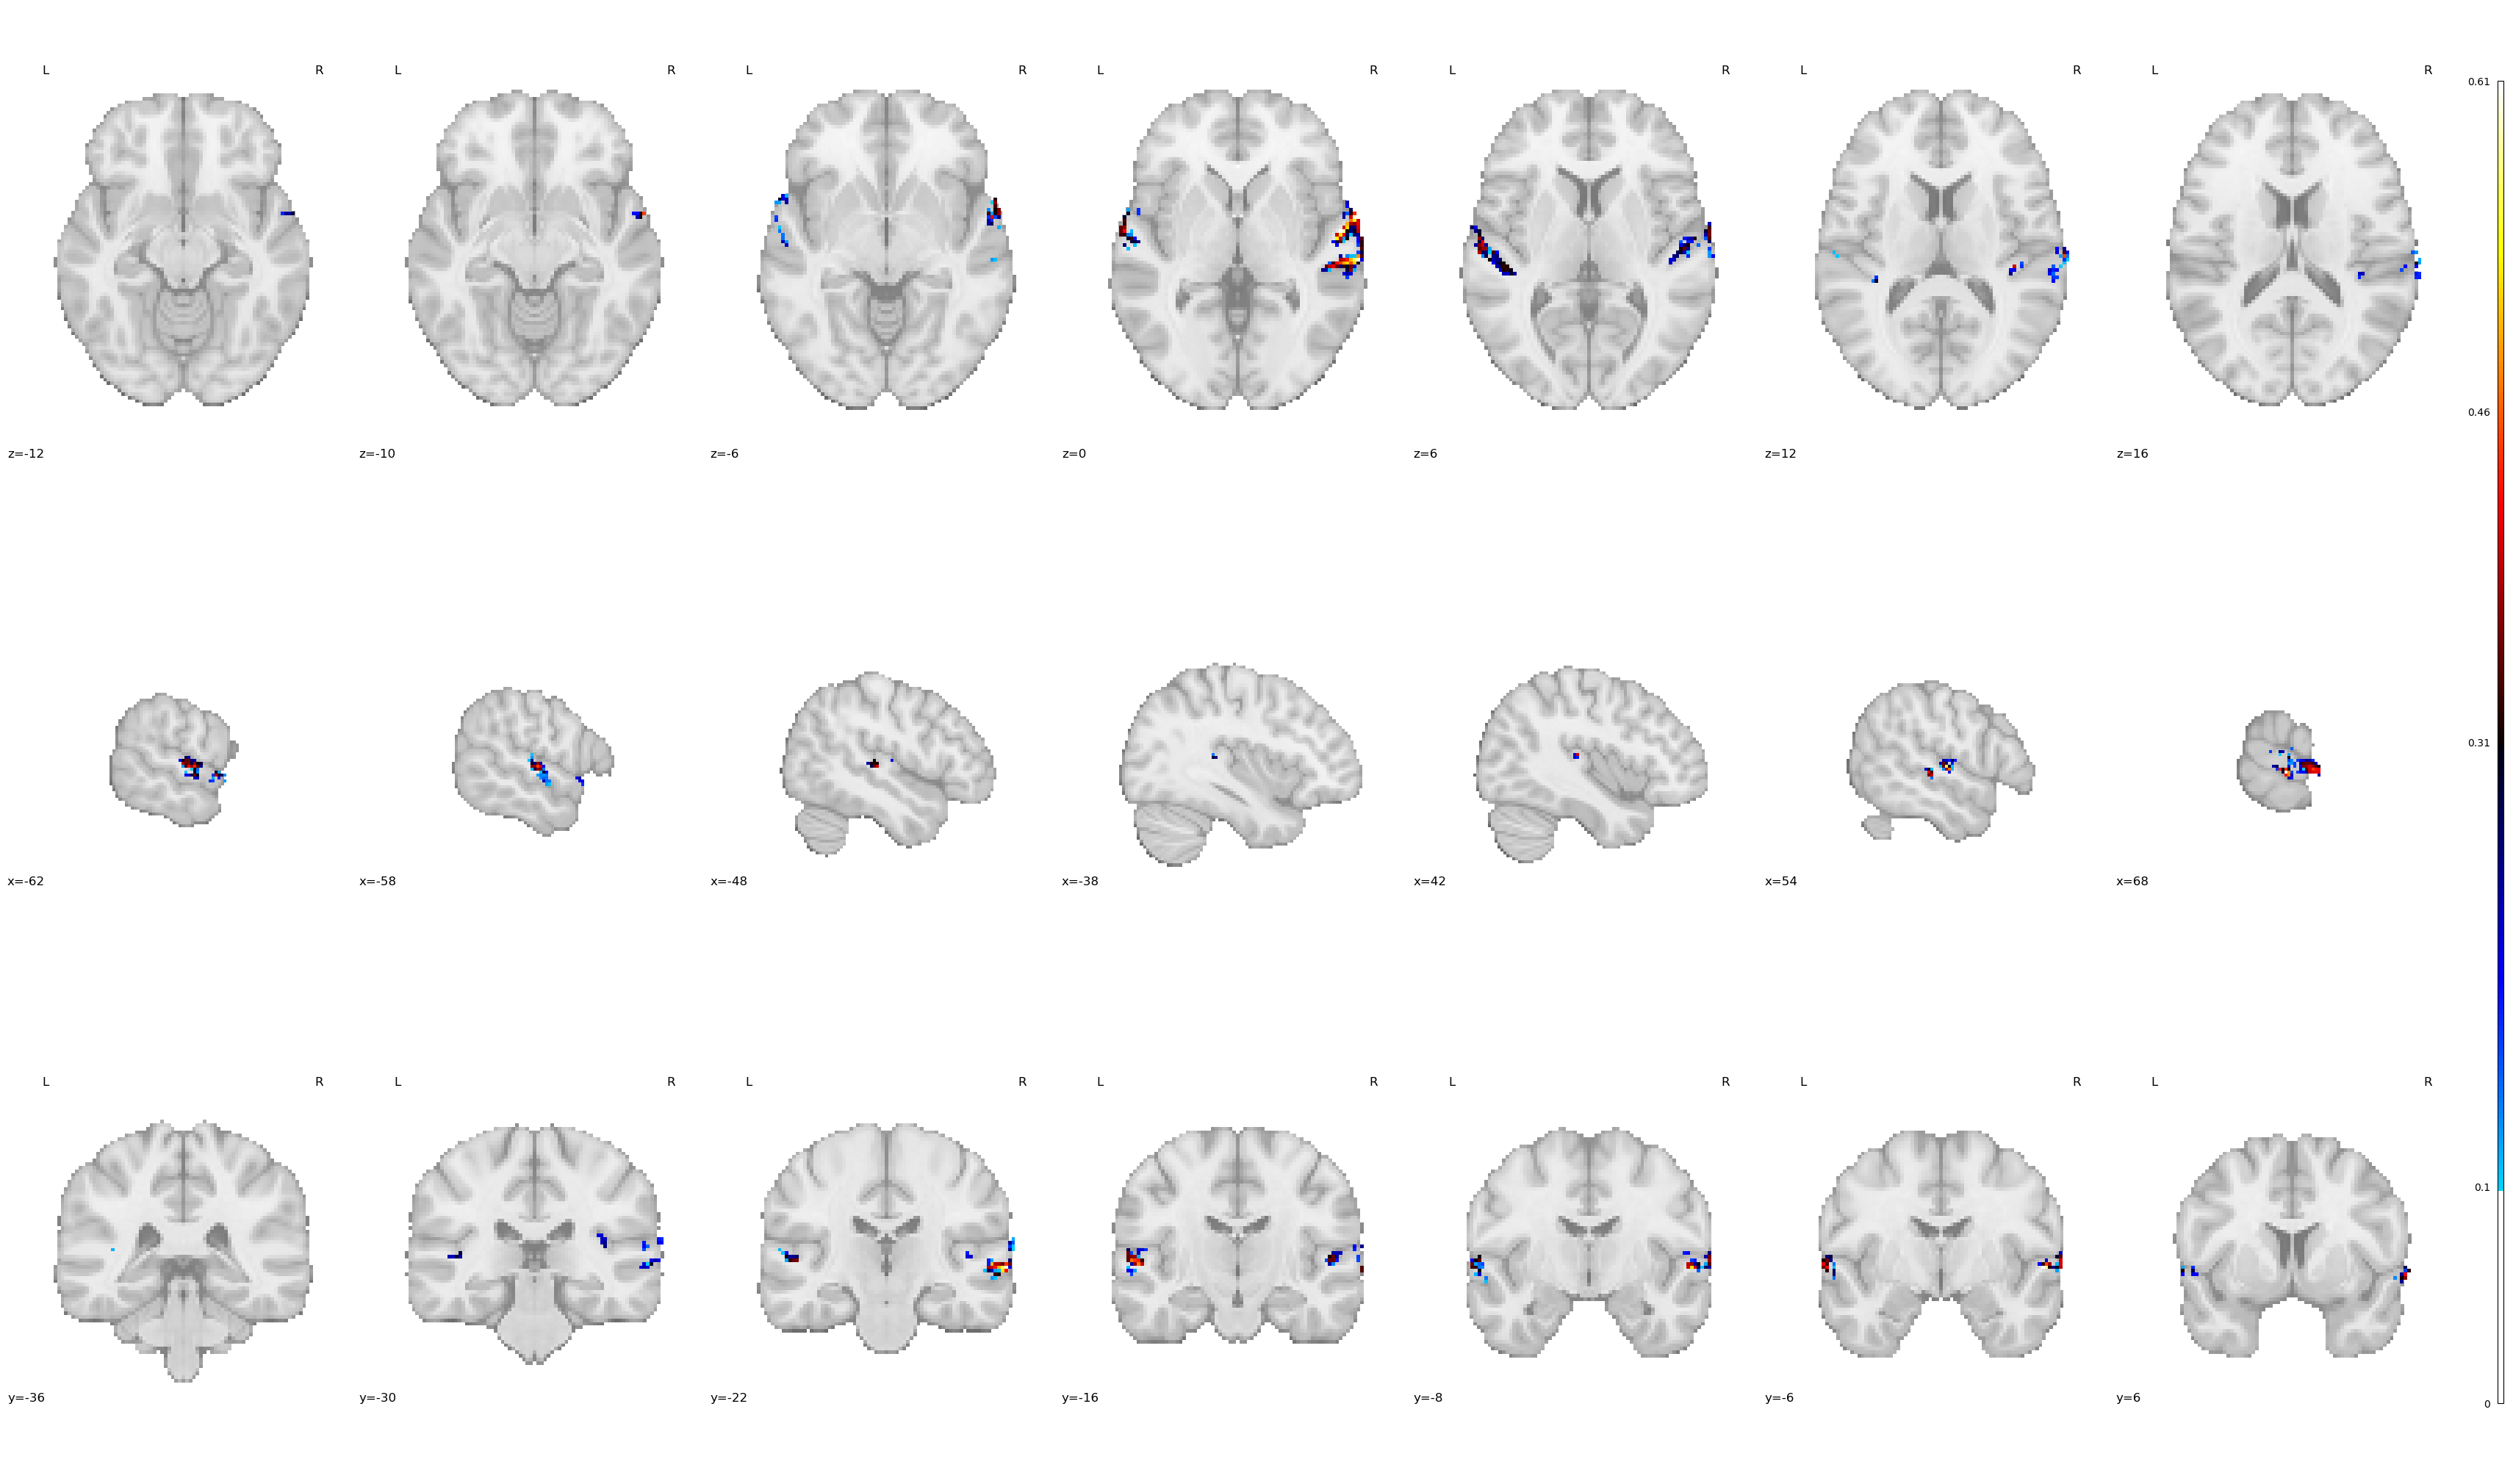

In [65]:
train_encode_model=True
thr=0.1    # thr=0.06
if train_encode_model:

    from sklearn.linear_model import RidgeCV

    voxel_models=[]
    voxels_scores=[]

    X=train_audio_feat.numpy()
    y=train_fmri_avg.numpy()

    pbar=tqdm.trange(train_fmri_avg.shape[-1],position=0)
    for v in pbar:
        vm=RidgeCV()
        y_v=y[:,v]
        vm.fit(X,y_v)
        score=vm.score(X, y_v)
        voxel_models.append(vm)
        voxels_scores.append(score)
        pbar.set_description(f"score {score}")
        
    voxels_scores=np.array(voxels_scores)
    plt.hist(voxels_scores)
    R2_img=masker.inverse_transform(np.array(voxels_scores))
    
    R2_img_smooth=nilearn.image.smooth_img(R2_img,1)
    R2_img_smooth=nilearn.image.threshold_img(R2_img_smooth,threshold=thr,cluster_threshold=100)
    R2_data=R2_img_smooth.get_fdata()

    R2_data_masked=masker.transform(R2_img_smooth)
    selected_indices=(R2_data_masked>0)
    print(selected_indices.sum())
    plotting.plot_stat_map(R2_img_smooth,display_mode="mosaic",colorbar=True,threshold=thr)
    
    #save mask
    binary_mask=(R2_data_masked>0)*1.
    mask=masker.inverse_transform(binary_mask.squeeze())
    nib.save(mask,"mask.nii.gz")
else:
    selected_indices=masker.transform(nib.load("mask.nii.gz"))

In [89]:
nib.save(R2_img_smooth,"maskR2.nii.gz")

# Back to image with R2 scores, voxel selection

## Connect selected voxels with cluster labels, can we classify these musical genres?

In [66]:
X_train=train_fmri_avg[:,selected_indices.squeeze()]
X_test=test_fmri_avg[:,selected_indices.squeeze()]

y_train = kmeans.predict(train_audio_feat)
y_test = kmeans.predict(test_audio_feat)

## Save maskbinary_mask

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(C=0.1,random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.27      0.14      0.19        21
           1       0.50      0.39      0.44        33
           2       0.33      0.36      0.34        14
           3       0.26      0.56      0.35        16
           4       0.55      0.59      0.57        27
           5       0.47      0.38      0.42        24
           6       0.40      0.40      0.40        10
           7       0.12      0.16      0.14        19
           8       0.40      0.46      0.43        46
           9       0.71      0.47      0.57        36

    accuracy                           0.41       246
   macro avg       0.40      0.39      0.38       246
weighted avg       0.44      0.41      0.41       246



## Genre classification

In [68]:
from sklearn.preprocessing import LabelEncoder
    
le=LabelEncoder()
train_genre_enc=le.fit_transform(train_genre)
test_genre_enc=le.transform(test_genre)

In [69]:
clf_genre = LogisticRegression(C=1,random_state=0).fit(X_train, train_genre_enc)
y_pred_genre = clf_genre.predict(X_test)

print(classification_report(test_genre_enc,y_pred_genre))


              precision    recall  f1-score   support

           0       0.28      0.29      0.29        24
           1       0.72      0.88      0.79        24
           2       0.37      0.29      0.33        24
           3       0.30      0.25      0.27        24
           4       0.61      0.58      0.60        24
           5       0.53      0.38      0.44        26
           6       0.32      0.40      0.36        25
           7       0.50      0.64      0.56        25
           8       0.50      0.31      0.38        26
           9       0.12      0.17      0.14        24

    accuracy                           0.42       246
   macro avg       0.43      0.42      0.42       246
weighted avg       0.43      0.42      0.42       246



## Ceiling

In [70]:
clf_ceiling = LogisticRegression(C=1,random_state=0).fit(train_audio_feat, train_genre_enc)
y_pred_ceil = clf_ceiling.predict(test_audio_feat)

print(classification_report(test_genre_enc,y_pred_ceil))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        24
           1       1.00      1.00      1.00        24
           2       0.69      0.92      0.79        24
           3       0.90      0.79      0.84        24
           4       0.83      0.83      0.83        24
           5       0.79      0.85      0.81        26
           6       0.71      0.68      0.69        25
           7       0.62      0.80      0.70        25
           8       0.87      0.77      0.82        26
           9       0.57      0.33      0.42        24

    accuracy                           0.75       246
   macro avg       0.75      0.75      0.74       246
weighted avg       0.75      0.75      0.74       246



## Contrastive Learning to retrieve actual songs

In [71]:
from importlib import reload # python 2.7 does not require this
import networks
reload(networks)

from networks import Encoder, ContrastiveModel
import torch
from torch import nn
import pytorch_lightning as pl


In [72]:
train_dataset=torch.utils.data.TensorDataset(torch.Tensor(X_train).float(), torch.Tensor(train_audio_feat).float(), torch.ones(len(X_train))) #single subject
test_dataset=torch.utils.data.TensorDataset(torch.Tensor(X_test).float(), torch.Tensor(test_audio_feat).float(),torch.ones(len(X_test)))


In [73]:
BS=64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, shuffle=True)


In [74]:
brain_model = ContrastiveModel(num_input_channels= X_train.shape[-1], base_channel_size=[768], latent_dim=512,act_fn=nn.GELU, loss_type="contrastive", common_dim=812)


In [75]:
# Instantiate a PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=20, devices=[1])

# Train the model
trainer.fit(brain_model, train_dataloader, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/matteoc/genre-to-fmri/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name  | Type    | Params
----------------------------------
0 | model | Encoder | 0     
----------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 142.31it/s, v_num=0, train_loss_step=1.530, val_loss=3.220, val_mse_loss=0.00351, val_cosine_similarity=0.225, train_loss_epoch=1.750]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 107.05it/s, v_num=0, train_loss_step=1.530, val_loss=3.220, val_mse_loss=0.00351, val_cosine_similarity=0.225, train_loss_epoch=1.750]


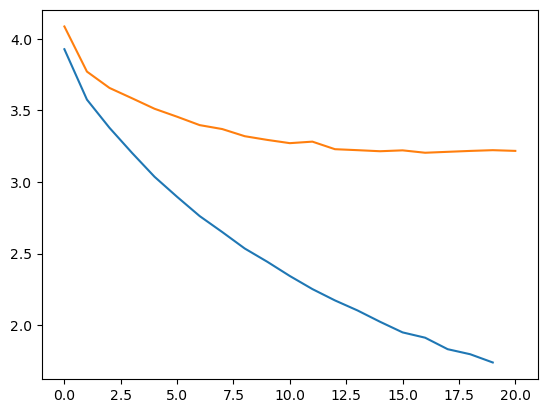

In [76]:
plt.plot(brain_model.train_history["train_loss"], label='train')
plt.plot(brain_model.val_history["val_loss"], label='val')

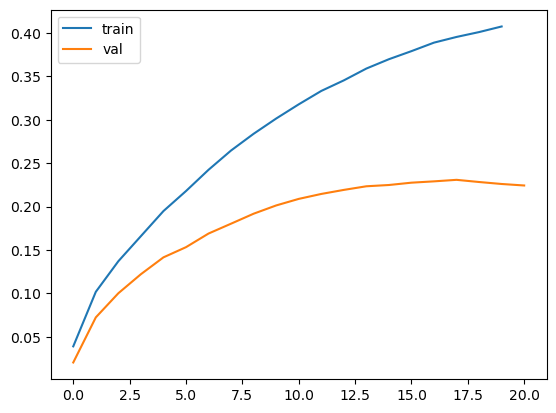

In [77]:
plt.plot(brain_model.train_history["train_cosine"], label='train')
plt.plot(brain_model.val_history["val_cosine"], label='val')

plt.legend()

In [78]:
x,y,k=next(iter(test_dataloader))

z_pred=[]
with torch.no_grad():

    for x,y,k in tqdm.tqdm(test_dataloader):
        y_hat=brain_model(x,k=k).cpu()
        z_pred.append(y_hat)

z_pred=torch.cat(z_pred,0)


100%|██████████| 4/4 [00:00<00:00, 86.96it/s]


In [79]:
# similarity=  torch.nn.functional.softmax(.1*torch.nn.functional.normalize(test_clip_img_embeds[:,0],-1) @ torch.nn.functional.normalize(y_pred,.1).T)

z_i=z_pred
z_j=torch.Tensor(test_audio_feat).float()

z_i = nn.functional.normalize(z_i, dim=1)
z_j = nn.functional.normalize(z_j, dim=1)

logits = (z_i @ z_j.T) / .1

similarity =  torch.nn.functional.softmax(logits,-1)
top_indices=torch.topk(similarity,10,1).indices
# similarity=  torch.nn.functional.softmax(10*torch.nn.functional.normalize(test_clip_img_embeds[:,0],-1) @ torch.nn.functional.normalize(y_pred.T,-1))

In [80]:
import seaborn as sns
import IPython.display as ipd

<AxesSubplot:>

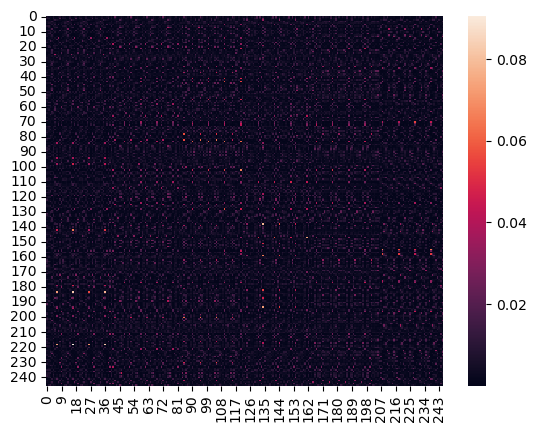

In [81]:
sns.heatmap(similarity)

In [86]:
idx=0
print(test_genre[idx])
ipd.Audio(test_audio[idx],rate=test_sr[idx])

pop


In [88]:

print(test_genre[top_indices[idx]])
ipd.Audio(test_audio[top_indices[idx][-1]],rate=test_sr[idx])

['hiphop' 'hiphop' 'hiphop' 'hiphop' 'hiphop' 'pop' 'pop' 'disco' 'disco'
 'pop']


In [84]:
top_indices[idx]

tensor([ 94, 237, 217, 227, 104,   6,  86,  75,  84,  16])

In [85]:
## quantitative
acc=0
for idx in range(len(X_test)):
    if test_genre[idx] in test_genre[top_indices[idx]]:
        acc+=1

acc/=len(X_test)
acc

0.2682926829268293